<a href="https://colab.research.google.com/github/matchbou/kaggle-study-20190410/blob/master/lightgbm-to-titanic-dataset_Kaggle.pdf-201904161407.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://www.kaggle.com/shep312/applying-lightgbm-to-titanic-dataset

# lightgbm-to-titanic-dataset_Kaggle.pdf

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matchbou","key":"fb2093338e9cd630d62e0949908398dc"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!pip install kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# kaggleデータ置き場とjupyernoteのカレントディレクトリフォルダを作成

!mkdir ./input
!mkdir ./notebook

In [7]:
#osライブラリ読込してinputに移動⇒kaggleデータもダウンロード　⇒ notebookフォルダに移動
import os
os.chdir('input')

#https://www.kaggle.com/c/titanic/data
!kaggle competitions download -c titanic

os.chdir('../notebook')


  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 23.9MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 24.7MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.79MB/s]


In [8]:
#上記操作の結果以下のディレクトリ配置となる

# /content/notebook このipynbのカレントディレクトリ
# /content/input カグルからダウンロードしたcsvファイルの置き場所

!pwd
!ls -a ../input


/content/notebook
.  ..  gender_submission.csv  test.csv	train.csv


In [0]:
#ここからカーネルの内容に踏み込む

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
%matplotlib inline

In [11]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [0]:
# Not sure passenger ID is useful as a feature, but need to save it from the test set for the submission
test_passenger_ids = test_df.pop('PassengerId')
train_df.drop(['PassengerId'], axis=1, inplace=True)

# 'Embarked' is stored as letters, so fit a label encoder to the train set to use in the loop
embarked_encoder = LabelEncoder()
embarked_encoder.fit(train_df['Embarked'].fillna('Null'))

# Dataframes to work on
df_list = [train_df, test_df]

for df in df_list:    
    
    # Record anyone travelling alone
    df['Alone'] = (df['SibSp'] == 0) & (df['Parch'] == 0)
    
    # Transform 'Embarked'
    df['Embarked'].fillna('Null', inplace=True)
    df['Embarked'] = embarked_encoder.transform(df['Embarked'])
    
    # Transform 'Sex'
    df.loc[df['Sex'] == 'female','Sex'] = 0
    df.loc[df['Sex'] == 'male','Sex'] = 1
    df['Sex'] = df['Sex'].astype('int8')
    
    # Drop features that seem unusable. Save passenger ids if test
    df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [0]:
# Separate the label
y = train_df.pop('Survived')

# Take a hold out set randomly
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)

# Create an LGBM dataset for training
categorical_features = ['Alone', 'Sex', 'Pclass', 'Embarked']
train_data = lgbm.Dataset(data=X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)

# Create an LGBM dataset from the test
test_data = lgbm.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

# Finally, create a dataset for the FULL training data to give us maximum amount of data to train on after 
# performance has been calibrate
final_train_set = lgbm.Dataset(data=train_df, label=y, 
                               categorical_feature=categorical_features, free_raw_data=False)

In [0]:
lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
              }

In [15]:
evaluation_results = {}
clf = lgbm.train(train_set=train_data,
                 params=lgbm_params,
                 valid_sets=[train_data, test_data], 
                 valid_names=['Train', 'Test'],
                 evals_result=evaluation_results,
                 num_boost_round=500,
                 early_stopping_rounds=100,
                 verbose_eval=20
                )
optimum_boost_rounds = clf.best_iteration

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/usr/local/lib/python3.6/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	Train's binary_logloss: 0.495352	Test's binary_logloss: 0.53227
[40]	Train's binary_logloss: 0.427865	Test's binary_logloss: 0.473512
[60]	Train's binary_logloss: 0.409228	Test's binary_logloss: 0.457064
[80]	Train's binary_logloss: 0.39052	Test's binary_logloss: 0.440822
[100]	Train's binary_logloss: 0.383936	Test's binary_logloss: 0.439535
[120]	Train's binary_logloss: 0.372745	Test's binary_logloss: 0.434008
[140]	Train's binary_logloss: 0.361276	Test's binary_logloss: 0.427183
[160]	Train's binary_logloss: 0.364341	Test's binary_logloss: 0.429825
[180]	Train's binary_logloss: 0.347134	Test's binary_logloss: 0.420026
[200]	Train's binary_logloss: 0.332	Test's binary_logloss: 0.414654
[220]	Train's binary_logloss: 0.325805	Test's binary_logloss: 0.409202
[240]	Train's binary_logloss: 0.314539	Test's binary_logloss: 0.404126
[260]	Train's binary_logloss: 0.307379	Test's binary_logloss: 0.401503
[280]	Train's binary_logloss: 0.296328	Test's binary_logloss: 0.399812
[300]	Train's b

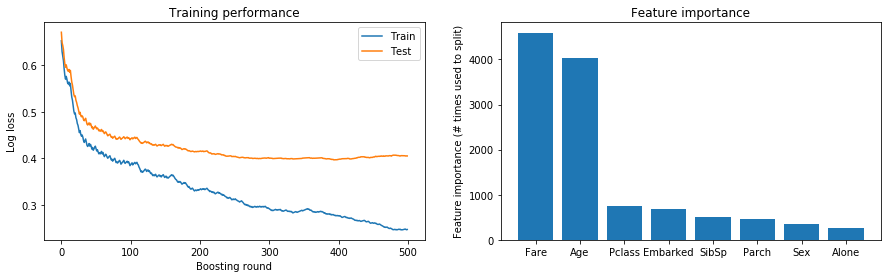

In [16]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [17]:
preds = np.round(clf.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.8379888268156425
Precision score = 	 0.8169014084507042
Recall score =   	 0.7837837837837838
F1 score =      	 0.8


In [20]:
optimum_boost_rounds

0

In [21]:
clf_final = lgbm.train(train_set=final_train_set,
                      params=lgbm_params,
                      #num_boost_round=optimum_boost_rounds,
                       num_boost_round=500,
                      verbose_eval=0
                      )

y_pred = np.round(clf_final.predict(test_df)).astype(int)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [0]:
output_df = pd.DataFrame({'PassengerId': test_passenger_ids, 'Survived': y_pred})

In [0]:
output_df.to_csv('lightgbm-to-titanic-dataset-output_df.csv')

In [0]:
from google.colab import files

files.download('lightgbm-to-titanic-dataset-output_df.csv')